# Shanice's version from Ryan's SOSE code

# SOSE Heat Budget

Evaluating the conservation of heat content in the Southern Ocean State Estimate 

Author: [Shanice Bailey](https://github.com/stb2145)

![SOSE Logo](http://sose.ucsd.edu/images/SOSEpic.png)

In [1]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
%matplotlib inline

## Open SOSE Dataset from Gyre

In [2]:
from dask.distributed import Client, LocalCluster, progress
cluster = LocalCluster(n_workers=4, threads_per_worker=8, ip='*')
client = Client(cluster)
client

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/distributed/bokeh/core.py:57: UserWarning: 
Port 8787 is already in use. 
Perhaps you already have a cluster running?
Hosting the diagnostics dashboard on a random port instead.
  warnings.warn('\n' + msg)


Client Scheduler: tcp://129.236.21.48:33131 Dashboard: http://129.236.21.48:45238/status,Cluster Workers: 4 Cores: 32 Memory: 480.84 GB


In [3]:
ds = xr.open_zarr('/swot/SUM03/tmp/SOSE')
ds

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
    Depth     (YC, XC) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefC    (Z) float32 dask.array<shape=(42,), chunksize=(42,)>
    PHrefF    (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
    drC       (Zp1) float32 dask.ar

Optimization trick from Ryan's NB: split ds into coords and data variables then drop coordinates from data variables.

In [4]:
coords = ds.coords.to_dataset().reset_coords() #ds split into coords
dsr = ds.reset_coords(drop=True) #ds dropping coords so it just holds data variables
dsr

<xarray.Dataset>
Dimensions:   (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * XC        (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * XG        (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * YC        (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * YG        (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z         (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zl        (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * Zp1       (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
  * Zu        (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * time      (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Data variables:
    ADVr_SLT  (time, Zl, YC, XC) float32 dask.array<shape=(438, 42, 320, 2160), chunksize=(1, 42, 320, 2160)>
    ADVr_TH   (time, Zl, YC, XC) float32 dask.array<shap

In [5]:
coords

<xarray.Dataset>
Dimensions:  (XC: 2160, XG: 2160, YC: 320, YG: 320, Z: 42, Zl: 42, Zp1: 43, Zu: 42, time: 438)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Zl       (Zl) float32 0.0 -10.0 -21.0 -33.0 ... -4950.0 -5200.0 -5450.0
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * Zu       (Zu) float32 -10.0 -21.0 -33.0 -46.0 ... -5200.0 -5450.0 -5700.0
  * XG       (XG) float32 5.551115e-17 0.16666667 ... 359.6667 359.83334
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * Zp1      (Zp1) float32 0.0 -10.0 -21.0 -33.0 ... -5200.0 -5450.0 -5700.0
Data variables:
    dyG      (YC, XG) float32 dask.array<shape=(320, 2160), chunksize=(320, 2160)>
    PHrefF   (Zp1) float32 dask.array<shape=(43,), chunksize=(43,)>
    dxG      (YG, XC) flo

## Create XGCM Grid

In [6]:
import xgcm
grid = xgcm.Grid(ds, periodic=('XC', 'YC'))
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
T Axis (not periodic):
  * center   time
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center

## Tracer Budgets

Here we will do the heat budget for SOSE. In integral form, this budget can be written as

$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be eventually repeated for both tracers.

## Heat component of buoyancy budget integrated over Weddell Sea Region
Here, $\mathcal{V}$, represents the closed system of the Weddell Sea.

$$
\int_{R}{\frac{\partial{\theta}}{\partial{t}}}d\mathcal{V} = -\int_{NB}F^{\theta}_{adv,y}dA - \int_{NB} F^{\theta}_{diff,y}dA - \int_{surf}\frac{\partial}{\partial{z}}F^{\theta}_{surf}\vert_{z=0}dA
$$

where 'NB' denotes northern boundary of region R; 'surf' represents the boundary closed by the ocean surface; and $F^{\theta}_{surf}$ term includes the above $G^{\theta}_{surf}$ and $G^{\theta}_{sw}$. Both the first term and second term represents the the northern boundary crossing of the meridional advective flux and meridional diffusive flux, respectively; and the last term represents the surface flux crossing the ocean surface area.

Left-hand side can be written as: $\mathcal{V}\frac{\partial{\theta}}{\partial{t}}$ since $V = \int_{R}\mathcal{H}(\tilde{\theta} - \theta)\ dV$

In [7]:
coords.rAs

<xarray.DataArray 'rAs' (YG: 320, XC: 2160)>
dask.array<shape=(320, 2160), dtype=float32, chunksize=(320, 2160)>
Coordinates:
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
Attributes:
    long_name:      cell area
    standard_name:  cell_area_at_v_location
    units:          m2

In [8]:
#adv flux terms already take into acct cell area (look at the units)
dsr.ADVy_TH

<xarray.DataArray 'ADVy_TH' (time: 438, Z: 42, YG: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Advective Flux of Pot.Temperature
    mate:           ADVx_TH
    standard_name:  ADVy_TH
    units:          degC.m^3/s

In [9]:
dsr.DFyE_TH

<xarray.DataArray 'DFyE_TH' (time: 438, Z: 42, YG: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 320, 2160)>
Coordinates:
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167
  * YG       (YG) float32 -77.9583 -77.79163 -77.62497 ... -24.9583 -24.791632
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
Attributes:
    long_name:      Meridional Diffusive Flux of Pot.Temperature
    mate:           DFxE_TH
    standard_name:  DFyE_TH
    units:          degC.m^3/s

In [10]:
first_term = grid.diff(dsr.ADVy_TH, 'Y', boundary='fill') + grid.diff(dsr.ADVx_TH, 'X', boundary='fill')
second_term = grid.diff(dsr.DFyE_TH, 'Y', boundary='fill') + grid.diff(dsr.DFxE_TH, 'X', boundary='fill')
third_term = -(grid.diff(dsr.ADVr_TH, 'Z', boundary='fill') + grid.diff(dsr.DFrE_TH, 'Z', boundary='fill') + 
               grid.diff(dsr.DFrI_TH, 'Z', boundary='fill') + grid.diff(dsr.KPPg_TH, 'Z', boundary='fill'))

In [11]:
first_term

<xarray.DataArray (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 42, 319, 2159)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167

In [12]:
#'YC' comes out because of `grid`
grid

<xgcm.Grid>
Z Axis (not periodic):
  * center   Z --> left
  * left     Zl --> center
  * outer    Zp1 --> center
  * right    Zu --> center
T Axis (not periodic):
  * center   time
Y Axis (not periodic):
  * center   YC --> left
  * left     YG --> center
X Axis (not periodic):
  * center   XC --> left
  * left     XG --> center

In [13]:
import timeit

In [14]:
#zooming in to WG region
#Longitude is closed boundary
#Latitude is not closed boundary
%timeit test = first_term.sel(XC=slice(290, 360), YC=slice(-80, -60)).sum(dim=('XC', 'YC', 'Z')).load()

1min 39s ± 3.93 s per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
test = first_term.sel(XC=slice(290, 360), YC=slice(-80, -60)).sum(dim=('XC', 'YC', 'Z')).load()

In [17]:
test

<xarray.DataArray (time: 438)>
array([-14517043. ,  -3930572. ,  -7398626. , ...,    759988.4,   3078618. ,
        -2053874.5], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

/home/sbailey/.conda/envs/pangeo/lib/python3.6/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


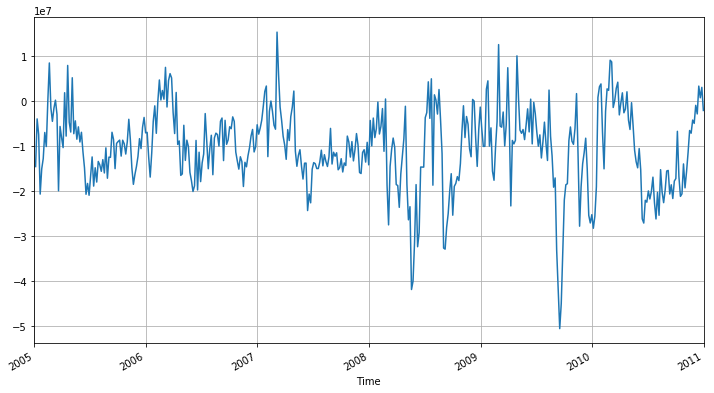

In [18]:
test.plot(figsize=(12,6))
plt.xlim('2005', '2011')
plt.grid();

In [19]:
heat_budget = - first_term - second_term - third_term
heat_budget

<xarray.DataArray (time: 438, Z: 42, YC: 320, XC: 2160)>
dask.array<shape=(438, 42, 320, 2160), dtype=float32, chunksize=(1, 41, 319, 2159)>
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
  * Z        (Z) float32 -5.0 -15.5 -27.0 -39.5 ... -5075.0 -5325.0 -5575.0
  * YC       (YC) float32 -77.87497 -77.7083 -77.54163 ... -24.874966 -24.7083
  * XC       (XC) float32 0.083333336 0.25 0.4166667 ... 359.75 359.9167

In [21]:
%timeit heat_budget_weddell = heat_budget.sel(XC=slice(290,360), YC=slice(-80,-60)).sum(dim=('XC', 'YC', 'Z')).load()

In [22]:
heat_budget_weddell = heat_budget.sel(XC=slice(290,360), YC=slice(-80,-60)).sum(dim=('XC', 'YC', 'Z')).load()
heat_budget_weddell

<xarray.DataArray (time: 438)>
array([14758144. ,  3924887. ,  7448393.5, ...,  -927000.2, -3184129. ,
        1987591.5], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31

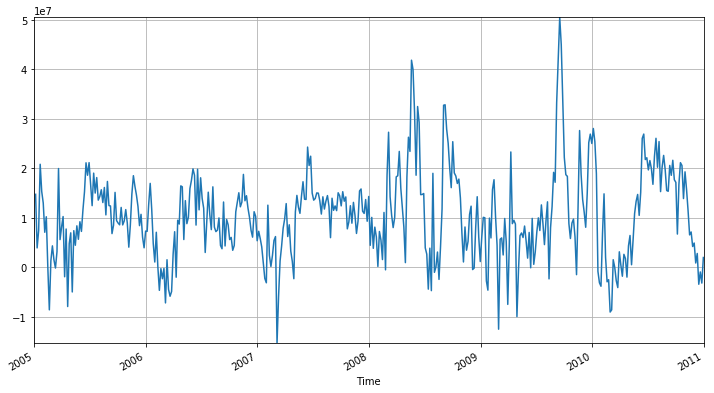

In [24]:
heat_budget_weddell.plot(figsize=(12,6))
plt.grid()
plt.xlim('2005', '2011')
plt.ylim(heat_budget_weddell.min(), heat_budget_weddell.max());

In [30]:
heat_budget_weddell_mm = heat_budget_weddell.groupby('time.month').mean(dim='time')
heat_budget_weddell_anom = heat_budget_weddell.groupby('time.month') - heat_budget_weddell_mm
heat_budget_weddell_anom

<xarray.DataArray (time: 438)>
array([  7167208. ,  -3666049. ,   -142542.5, ..., -10143027. , -12400156. ,
        -7228435.5], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 2005-01-06 2005-01-11 ... 2010-12-31
    month    (time) int64 1 1 1 1 1 1 2 2 2 2 ... 11 11 11 12 12 12 12 12 12 12

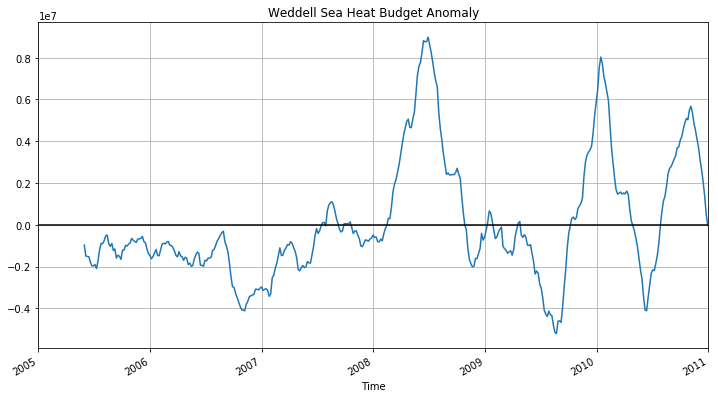

In [41]:
heat_budget_weddell_anom.rolling(time=30).mean().plot(figsize=(12,6))
plt.grid()
plt.xlim('2005', '2011')
plt.axhline(y=0, color='k')
plt.title('Weddell Sea Heat Budget Anomaly');